# Лингвистический центр

In [79]:
# импортируем библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import os
import time

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor, Pool

import warnings
RS = 8

In [80]:
df=pd.read_excel("C:\\Users\\Sergey\\Downloads\\Тестовое\\BI-тестовое задание.xlsx")
df.head()

,Заказ,Дата продажи,Сумма,Проданный заказ,Клиент,Сумма исполнителю,Дата выручки,Дата оплаты,Статус счета,Дата акта,Неоплаченная сумма
0,S_167,2022-01-31,14311.883410,NaN,К1,3494.390134,2022-03-01,2022-03-11,Оплачена,2022-03-01,0
1,S_521,2022-03-10,5027.354260,NaN,К1,2613.901345,2022-04-01,2022-04-22,Оплачена,2022-04-01,0
2,VL112,2022-03-23,470.852017,NaN,К2,226.726457,2022-03-23,2022-03-23,Оплачена,NaT,0
3,S_218,2023-02-03,158.116591,NaN,К3,12.376681,2023-02-08,2023-02-10,Оплачена,2023-02-08,0
4,S_-31,2022-06-10,5064.538116,NaN,К4,665.040358,2022-06-27,2022-06-29,Оплачена,2022-06-27,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83958 entries, 0 to 83957
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Заказ               83957 non-null  object        
 1   Дата продажи        83958 non-null  datetime64[ns]
 2   Сумма               83958 non-null  float64       
 3   Проданный заказ     2893 non-null   object        
 4   Клиент              83958 non-null  object        
 5   Сумма исполнителю   82820 non-null  float64       
 6   Дата выручки        82590 non-null  datetime64[ns]
 7   Дата оплаты         81315 non-null  datetime64[ns]
 8   Статус счета        83958 non-null  object        
 9   Дата акта           51322 non-null  datetime64[ns]
 10  Неоплаченная сумма  83958 non-null  object        
dtypes: datetime64[ns](4), float64(2), object(5)
memory usage: 7.0+ MB


Описание данных

Заказ - уникальный код заказа клиента, стостоит из: код клиента + порядковый номер заказа этого клиента

Дата продажи - дата согласования заказа клиентом, появляется в момент переставление заказа в статус подтвержден

Сумма - сумма для клиента

Проданный заказ false - при переставлении заказа в отменен = false

Проданный заказ true - при переставлении заказа в подтвержден = true

Клиент - уникальный код  клиента

Сумма исполнителю - сумма для выплаты исполнителям

Дата выручки - Дата оплаты заказа клиентом, появляется только при условии, что заказ завершен и сдан клиенту

Дата оплаты - Дата оплаты заказа клиентом

Статус счета Нет спецификации - счет еще не выставлен клиенту

Статус счета Не оплачена - счет выставлен, но не оплачен клиентом

Статус счета Частично оплачена - клиентом оплачена не вся сумма

Статус счета Оплачена - счет полностью оплачен

Статус счета Просрочена - дата оплаты по договору наступила, но счет еще не оплачен

Статус счета Списание - клиент отказывается оплачивать счет/не выходит на связь, оплаты нет и не предвидится

Статус счета reinvoiced - клиент попросил внести правки и перевыставить счет, оплаты нет

Дата акта - дата выставления акта для клиента

Неоплаченная сумма - неоплаченная клиентом сумма ( при недоплате принимает положительное значение, при переплате - отрицательное)

In [82]:
#Посчитаем количество пустых значений.
df.isna().sum()

Заказ                     1
Дата продажи              0
Сумма                     0
Проданный заказ       81065
Клиент                    0
Сумма исполнителю      1138
Дата выручки           1368
Дата оплаты            2643
Статус счета              0
Дата акта             32636
Неоплаченная сумма        0
dtype: int64

In [83]:
report = df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = ((report['missing_values'] / df.shape[0])*100).round(3)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
Проданный заказ,81065,96.554
Дата акта,32636,38.872
Дата оплаты,2643,3.148
Дата выручки,1368,1.629
Сумма исполнителю,1138,1.355
Заказ,1,0.001
Дата продажи,0,0.000
Сумма,0,0.000
Клиент,0,0.000
Статус счета,0,0.000


Проблемы в данных:
    1. "Неоплаченная сумма" перевести во FLOAT
    2. Пропуски в данных Заказ, Проданный заказ, Сумма исполнителю, Дата выручки, Дата оплаты, Дата акта
    Что со всем этим делать, буду решать дальше.

# Предобоработка данных


In [84]:
#Посмотрим уникальные значения
df['Дата оплаты'].unique()

array(['2022-03-11T00:00:00.000000000', '2022-04-22T00:00:00.000000000',
       '2022-03-23T00:00:00.000000000', '2023-02-10T00:00:00.000000000',
       '2022-06-29T00:00:00.000000000', '2023-02-08T00:00:00.000000000',
       '2023-04-19T00:00:00.000000000', '2022-06-15T00:00:00.000000000',
       '2023-06-19T00:00:00.000000000', '2023-12-22T00:00:00.000000000',
       '2023-06-20T00:00:00.000000000', '2022-09-26T00:00:00.000000000',
       '2023-12-25T00:00:00.000000000', '2022-11-09T00:00:00.000000000',
       '2022-03-05T00:00:00.000000000', '2022-04-19T00:00:00.000000000',
       '2022-09-09T00:00:00.000000000', '2023-12-06T00:00:00.000000000',
       '2023-08-16T00:00:00.000000000', '2022-05-13T00:00:00.000000000',
       '2023-01-26T00:00:00.000000000', '2022-09-13T00:00:00.000000000',
       '2022-06-20T00:00:00.000000000', '2022-10-21T00:00:00.000000000',
       '2022-09-19T00:00:00.000000000', '2023-03-28T00:00:00.000000000',
       '2022-09-20T00:00:00.000000000', '2023-03-16

In [85]:
#Посмотрим уникальные значения
df['Неоплаченная сумма'].unique()

array([0, 2440.547085, -0.421524, ..., 16330.78924, 3125.923766,
       3558.887892], dtype=object)

In [86]:
#Изменим тип данных
z=['3,1E-5', '4,9E-5', '1,7E-5', '2,6E-5', '6,2E-5', '3,5E-5', '1,6E-5', '9,3E-5', '1,3E-5', '4,2E-5', '9,8E-5', '4,8E-5', 
   '4,4E-5', '5,3E-5', '5,2E-5', '3,4E-5']
z1=['0.000031', '0.000049', '0.000017', '0.000026', '0.000062', '0.000035', '0.000016', '0.000093', '0.000013', '0.000042',
   '0.000098', '0.000048', '0.000044', '0.000053', '0.000052', '0.000034']
df['Неоплаченная сумма']=df['Неоплаченная сумма'].replace(z, z1)
df['Неоплаченная сумма']=df['Неоплаченная сумма'].astype(float).round(2)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83958 entries, 0 to 83957
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Заказ               83957 non-null  object        
 1   Дата продажи        83958 non-null  datetime64[ns]
 2   Сумма               83958 non-null  float64       
 3   Проданный заказ     2893 non-null   object        
 4   Клиент              83958 non-null  object        
 5   Сумма исполнителю   82820 non-null  float64       
 6   Дата выручки        82590 non-null  datetime64[ns]
 7   Дата оплаты         81315 non-null  datetime64[ns]
 8   Статус счета        83958 non-null  object        
 9   Дата акта           51322 non-null  datetime64[ns]
 10  Неоплаченная сумма  83958 non-null  float64       
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 7.0+ MB


In [88]:
share_0_age = ((df['Заказ'].isna().sum() / 83958) * 100).round(3)
print("Доля пропусков в Заказ:", share_0_age,"% от всех данных")

Доля пропусков в Заказ: 0.001 % от всех данных


In [89]:
share_0_age = ((df['Проданный заказ'].isna().sum() / 83958) * 100).round(2)
print("Доля пропусков в Проданный заказ:", share_0_age,"% от всех данных")

Доля пропусков в Проданный заказ: 96.55 % от всех данных


In [90]:
share_0_age = ((df['Сумма исполнителю'].isna().sum() / 83958) * 100).round(2)
print("Доля пропусков в Сумма исполнителю:", share_0_age,"% от всех данных")

Доля пропусков в Сумма исполнителю: 1.36 % от всех данных


In [91]:
share_0_age = ((df['Дата выручки'].isna().sum() / 83958) * 100).round(2)
print("Доля пропусков в Дата выручки:", share_0_age,"% от всех данных")

Доля пропусков в Дата выручки: 1.63 % от всех данных


In [92]:
share_0_age = ((df['Дата оплаты'].isna().sum() / 83958) * 100).round(2)
print("Доля пропусков в Дата оплаты:", share_0_age,"% от всех данных")

Доля пропусков в Дата оплаты: 3.15 % от всех данных


In [93]:
share_0_age = ((df['Дата акта'].isna().sum() / 83958) * 100).round(2)
print("Доля пропусков в Дата акта:", share_0_age,"% от всех данных")

Доля пропусков в Дата акта: 38.87 % от всех данных


In [94]:
df = df.dropna(subset=['Дата оплаты', 'Дата выручки', 'Сумма исполнителю', 'Заказ'])

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80303 entries, 0 to 83957
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Заказ               80303 non-null  object        
 1   Дата продажи        80303 non-null  datetime64[ns]
 2   Сумма               80303 non-null  float64       
 3   Проданный заказ     2431 non-null   object        
 4   Клиент              80303 non-null  object        
 5   Сумма исполнителю   80303 non-null  float64       
 6   Дата выручки        80303 non-null  datetime64[ns]
 7   Дата оплаты         80303 non-null  datetime64[ns]
 8   Статус счета        80303 non-null  object        
 9   Дата акта           50280 non-null  datetime64[ns]
 10  Неоплаченная сумма  80303 non-null  float64       
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 7.4+ MB


In [96]:
#Выведем сводную таблицу с пропусками в Проданный заказ
df[df['Дата акта'].isnull()].describe()

,Сумма,Сумма исполнителю,Неоплаченная сумма
count,30023.000000,30023.000000,30023.000000
mean,3701.091294,1215.817488,-42.904411
std,7984.544905,3767.111636,2250.968420
min,0.000000,0.000000,-189267.600000
25%,682.867712,199.551569,0.000000
50%,1255.605380,326.959641,0.000000
75%,3139.013452,855.246636,0.000000
max,99661.681610,116267.905800,46368.430000


In [97]:
#Выведем сводную таблицу без пропусков в Дата акта
df1 = df.loc[df['Дата акта'].isna()==False]
df1.describe()

,Сумма,Сумма исполнителю,Неоплаченная сумма
count,50280.000000,50280.000000,50280.000000
mean,6854.287768,1836.297791,15.226512
std,12419.498646,4095.604562,820.098869
min,0.695067,0.000000,-88994.800000
25%,785.128923,178.056054,0.000000
50%,2295.414797,530.623318,0.000000
75%,6892.838565,1672.254484,0.000000
max,99808.282510,181044.609900,72914.320000


Удаление пропусков в "Дата акта" сильно влияет на показатели среднего и среднемедианного

In [98]:
#Выведем сводную таблицу с пропусками в Проданный заказ
df[df['Проданный заказ'].isnull()].describe()


,Сумма,Сумма исполнителю,Неоплаченная сумма
count,77872.000000,77872.000000,77872.000000
mean,5637.273227,1597.133339,-5.636033
std,11022.901724,3940.729118,1476.918224
min,0.000000,0.000000,-189267.600000
25%,733.183855,196.860984,0.000000
50%,1748.878923,425.336322,0.000000
75%,5201.793720,1317.487667,0.000000
max,99808.282510,124098.668200,72914.320000


In [99]:
#Выведем сводную таблицу без пропусков в Проданный заказ
df.loc[df['Проданный заказ'].isna()==False].describe()

,Сумма,Сумма исполнителю,Неоплаченная сумма
count,2431.000000,2431.000000,2431.000000
mean,6896.631910,1834.460715,-34.405981
std,12680.338856,5260.445350,2576.845767
min,17.264573,0.000000,-120915.980000
25%,759.069506,159.443945,0.000000
50%,2178.080717,511.825112,0.000000
75%,6724.466366,1588.522421,0.000000
max,96370.170400,181044.609900,24421.210000


Удаление пропусков в "Проданный заказ" сильно влияет на показатели среднего и среднемедианного


In [100]:
df['Проданный заказ'] = df['Проданный заказ']. fillna (df['Статус счета'])
z=['Оплачена', 'да', 'Частично оплачена', 'Не оплачена', 'Нет спецификации', 'Просрочена', 'Списание']
z1=['да', 'да','нет', 'нет','нет','нет','нет']
df['Проданный заказ']=df['Проданный заказ'].replace(z, z1)
df['Проданный заказ'].unique()

array(['да', True, 'нет'], dtype=object)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80303 entries, 0 to 83957
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Заказ               80303 non-null  object        
 1   Дата продажи        80303 non-null  datetime64[ns]
 2   Сумма               80303 non-null  float64       
 3   Проданный заказ     80303 non-null  object        
 4   Клиент              80303 non-null  object        
 5   Сумма исполнителю   80303 non-null  float64       
 6   Дата выручки        80303 non-null  datetime64[ns]
 7   Дата оплаты         80303 non-null  datetime64[ns]
 8   Статус счета        80303 non-null  object        
 9   Дата акта           50280 non-null  datetime64[ns]
 10  Неоплаченная сумма  80303 non-null  float64       
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 7.4+ MB


In [102]:
#с датой акта ничего не понятно, поставлю заглушку
df['Дата акта'] = df['Дата акта']. fillna (0)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80303 entries, 0 to 83957
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Заказ               80303 non-null  object        
 1   Дата продажи        80303 non-null  datetime64[ns]
 2   Сумма               80303 non-null  float64       
 3   Проданный заказ     80303 non-null  object        
 4   Клиент              80303 non-null  object        
 5   Сумма исполнителю   80303 non-null  float64       
 6   Дата выручки        80303 non-null  datetime64[ns]
 7   Дата оплаты         80303 non-null  datetime64[ns]
 8   Статус счета        80303 non-null  object        
 9   Дата акта           80303 non-null  object        
 10  Неоплаченная сумма  80303 non-null  float64       
dtypes: datetime64[ns](3), float64(3), object(5)
memory usage: 7.4+ MB


In [104]:
df

,Заказ,Дата продажи,Сумма,Проданный заказ,Клиент,Сумма исполнителю,Дата выручки,Дата оплаты,Статус счета,Дата акта,Неоплаченная сумма
0,S_167,2022-01-31,14311.883410,да,К1,3494.390134,2022-03-01,2022-03-11,Оплачена,2022-03-01 00:00:00,0.0
1,S_521,2022-03-10,5027.354260,да,К1,2613.901345,2022-04-01,2022-04-22,Оплачена,2022-04-01 00:00:00,0.0
2,VL112,2022-03-23,470.852017,да,К2,226.726457,2022-03-23,2022-03-23,Оплачена,0,0.0
3,S_218,2023-02-03,158.116591,да,К3,12.376681,2023-02-08,2023-02-10,Оплачена,2023-02-08 00:00:00,0.0
4,S_-31,2022-06-10,5064.538116,да,К4,665.040358,2022-06-27,2022-06-29,Оплачена,2022-06-27 00:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
83953,S_079,2023-02-02,1043.923766,да,К22,255.000000,2023-02-20,2023-05-25,Оплачена,2023-02-20 00:00:00,0.0
83954,S_863,2023-02-22,1505.363228,да,К96,609.291479,2023-04-03,2023-07-05,Оплачена,2023-04-03 00:00:00,0.0
83955,C_-26,2023-03-27,87721.367710,да,К209,26810.672650,2023-03-31,2023-04-19,Оплачена,2023-03-31 00:00:00,0.0
83956,D_312,2023-08-03,1439.461883,да,К15,230.744394,2023-08-03,2023-08-03,Оплачена,0,0.0


# Проверка аномалий

In [105]:
df.describe()

,Сумма,Сумма исполнителю,Неоплаченная сумма
count,80303.000000,80303.000000,80303.000000
mean,5675.397593,1604.317913,-6.506981
std,11078.729721,3987.262310,1521.910868
min,0.000000,0.000000,-189267.600000
25%,734.320627,195.479821,0.000000
50%,1757.847532,426.834080,0.000000
75%,5254.762331,1327.002242,0.000000
max,99808.282510,181044.609900,72914.320000


Есть нулевые значения в графах сумма и сумма исполнителю, будем дальше смотреть что с ними делать

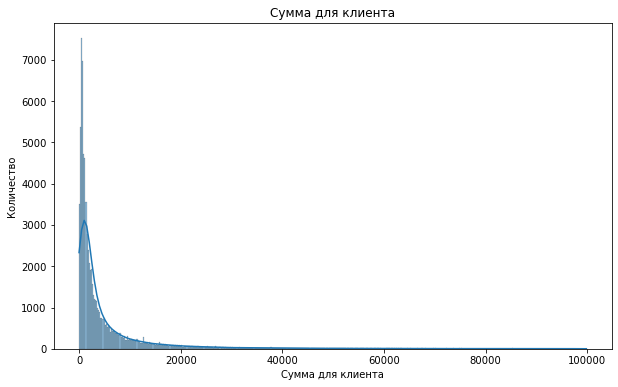

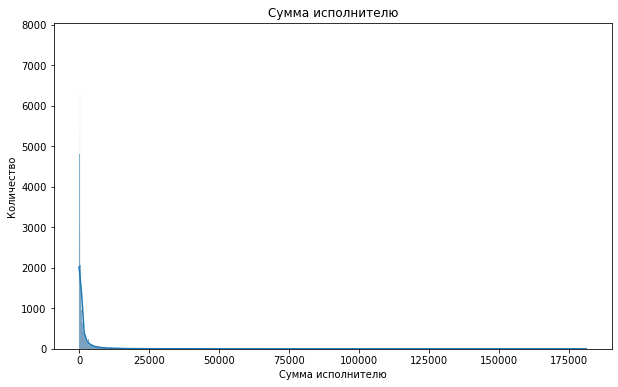

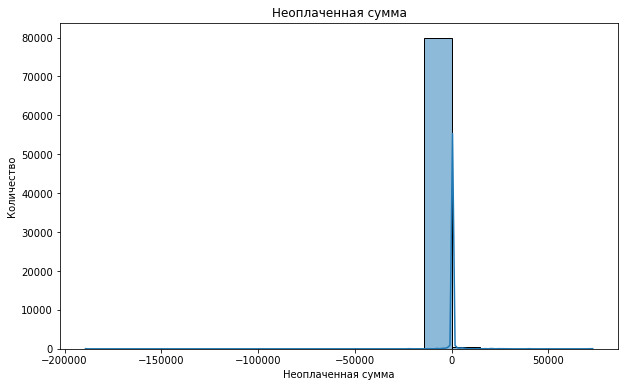

In [106]:
#выделим не категорийные значения

columns = ['Сумма', 'Сумма исполнителю', 'Неоплаченная сумма']
column_name = {'Сумма': 'Сумма для клиента', 'Сумма исполнителю': 'Сумма исполнителю', 'Неоплаченная сумма': 'Неоплаченная сумма'}

warnings.filterwarnings("ignore")
for column in columns:
    plt.figure(figsize=(10, 6))
    plt.title(column_name[column])
    sns.histplot(data=df, x=column, kde=True)  
    plt.xlabel(column_name[column])  
    plt.ylabel('Количество')
    plt.show()

Сумма для клиентов не может быть нулевой - это анамалия

Сумма исполнителю, Неоплаченная сумма может быть нулевой и Неоплаченная сумма может быть отрицательной

In [107]:
# фильтрация
df_filter=df[df['Сумма']>0]
df_filter.describe()

,Сумма,Сумма исполнителю,Неоплаченная сумма
count,80292.000000,80292.000000,80292.000000
mean,5676.175122,1604.503426,-6.447438
std,11079.289423,3987.503402,1521.999427
min,0.695067,0.000000,-189267.600000
25%,734.808295,195.515694,0.000000
50%,1757.847533,426.905829,0.000000
75%,5256.866591,1327.193945,0.000000
max,99808.282510,181044.609900,72914.320000


# Анализ данных

## Анализ клиентов

In [108]:
# Проверим как зависит сумма от даты продажи, сравним два последних года

In [109]:
df_filter['Год продажи']=df_filter['Дата продажи']
df_filter.loc[:, 'Год продажи'] = df_filter.loc[:, 'Год продажи'].dt.year

In [110]:
df_filter

,Заказ,Дата продажи,Сумма,Проданный заказ,Клиент,Сумма исполнителю,Дата выручки,Дата оплаты,Статус счета,Дата акта,Неоплаченная сумма,Год продажи
0,S_167,2022-01-31,14311.883410,да,К1,3494.390134,2022-03-01,2022-03-11,Оплачена,2022-03-01 00:00:00,0.0,2022
1,S_521,2022-03-10,5027.354260,да,К1,2613.901345,2022-04-01,2022-04-22,Оплачена,2022-04-01 00:00:00,0.0,2022
2,VL112,2022-03-23,470.852017,да,К2,226.726457,2022-03-23,2022-03-23,Оплачена,0,0.0,2022
3,S_218,2023-02-03,158.116591,да,К3,12.376681,2023-02-08,2023-02-10,Оплачена,2023-02-08 00:00:00,0.0,2023
4,S_-31,2022-06-10,5064.538116,да,К4,665.040358,2022-06-27,2022-06-29,Оплачена,2022-06-27 00:00:00,0.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
83953,S_079,2023-02-02,1043.923766,да,К22,255.000000,2023-02-20,2023-05-25,Оплачена,2023-02-20 00:00:00,0.0,2023
83954,S_863,2023-02-22,1505.363228,да,К96,609.291479,2023-04-03,2023-07-05,Оплачена,2023-04-03 00:00:00,0.0,2023
83955,C_-26,2023-03-27,87721.367710,да,К209,26810.672650,2023-03-31,2023-04-19,Оплачена,2023-03-31 00:00:00,0.0,2023
83956,D_312,2023-08-03,1439.461883,да,К15,230.744394,2023-08-03,2023-08-03,Оплачена,0,0.0,2023


Text(0.5, 1.0, 'Продажи по годам')

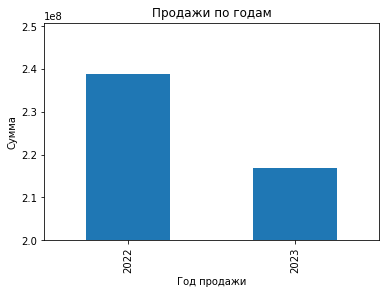

In [111]:
df_filter['Сумма'].groupby(df_filter['Год продажи']).sum().plot(kind='bar')
plt.ylim(200000000, )
plt.ylabel('Сумма')  
plt.title('Продажи по годам')


In [112]:
df_2022=df_filter['Сумма'][df_filter['Год продажи']<2023].sum()


In [113]:
df_2023=df_filter['Сумма'][df_filter['Год продажи']>2022].sum()


In [114]:
print('Изменение суммы продаж соcтавило:', (df_2023-df_2022).round(2))

Изменение суммы продаж соcтавило: -21921764.43


Видно падение продаж в 2023 году.

In [115]:
# Проверим как менялась сумма от даты продажи каждого пользователя, сравним два последних года

Text(0.5, 1.0, 'Продажи за 2022 год')

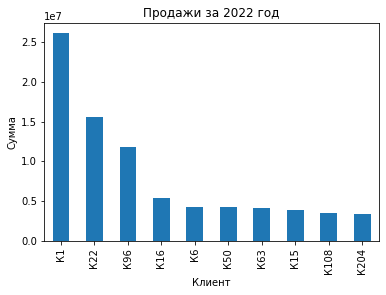

In [116]:
df_2022=df_filter[df_filter['Год продажи'] == 2022].groupby([df_filter['Клиент']])['Сумма'].sum().sort_values( ascending=False)
df_2022.head(10).plot(kind='bar')
plt.ylabel('Сумма') 
plt.title('Продажи за 2022 год')

Text(0.5, 1.0, 'Продажи за 2023 год')

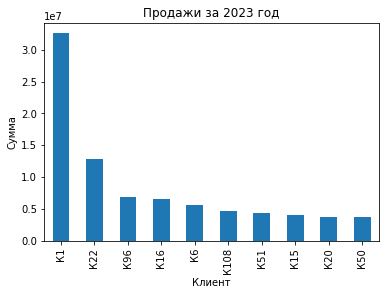

In [117]:
df_2023=df_filter[df_filter['Год продажи'] == 2023].groupby([df_filter['Клиент']])['Сумма'].sum().sort_values( ascending=False)
df_2023.head(10).plot(kind='bar')
plt.ylabel('Сумма')  
plt.title('Продажи за 2023 год')


В первой пятерке клиентов по продажам изменеий не наблюдается

In [118]:
# Посчитаем колличество родаж за год по клиентам


In [119]:
df_2022=df_filter['Сумма'][df_filter['Год продажи']<2023].count()
print('Количество продаж в 2022 году', df_2022)

Количество продаж в 2022 году 43752


In [120]:
df_2023=df_filter['Сумма'][df_filter['Год продажи']>2022].count()
print('Количество продаж в 2023 году', df_2023)

Количество продаж в 2023 году 36540


Text(0.5, 1.0, 'Количество продаж по годам')

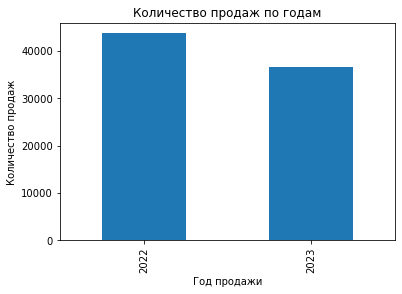

In [121]:
df_filter['Сумма'].groupby(df_filter['Год продажи']).count().plot(kind='bar')
plt.ylabel('Количество продаж')  
plt.title('Количество продаж по годам')

In [122]:
print('Изменение количества продаж соcтавило:', (df_2023-df_2022))

Изменение количества продаж соcтавило: -7212


Видно падение количества продаж в 2023 году

Text(0.5, 1.0, 'Количество продаж в 2022 году')

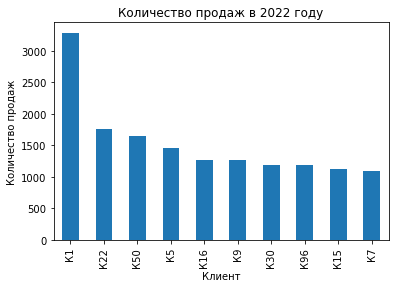

In [123]:
df_2022=df_filter[df_filter['Год продажи'] == 2022].groupby([df_filter['Клиент']])['Сумма'].count().sort_values( ascending=False)
df_2022.head(10).plot(kind='bar')
plt.ylabel('Количество продаж') 
plt.title('Количество продаж в 2022 году')

Text(0.5, 1.0, 'Количество продаж в 2023 году')

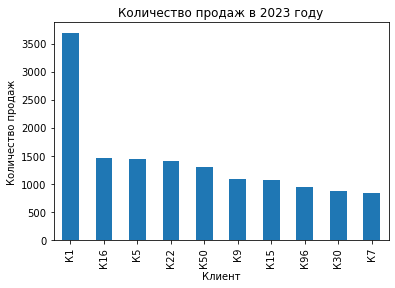

In [124]:
df_2023=df_filter[df_filter['Год продажи'] == 2023].groupby([df_filter['Клиент']])['Сумма'].count().sort_values( ascending=False)
df_2023.head(10).plot(kind='bar')
plt.ylabel('Количество продаж') 
plt.title('Количество продаж в 2023 году')

В первой десятке изменений не наблюдается

Промежуточный вывод:
    Наблюдается падение продаж услуг за 2023 год (-7212 штук) и, как следствие, падение выручки (-21921764.43 у.е.). По клиентам в в первой пятерке как по количеству услуг, так и по стоимости изменеий не наблюдается.

In [125]:
## Зависимость не оплаты по годам

def неоплаченная_сумма(x):
    if x < 0:
        return 'Неоплата'
    elif x > 0:
        return 'Переплата'
    else:
        return '0'

df_filter['Статус оплаты'] = df['Неоплаченная сумма'].apply(неоплаченная_сумма)
df_filter.groupby('Статус оплаты')['Неоплаченная сумма'].count()


Статус оплаты
0            76909
Неоплата      2705
Переплата      678
Name: Неоплаченная сумма, dtype: int64

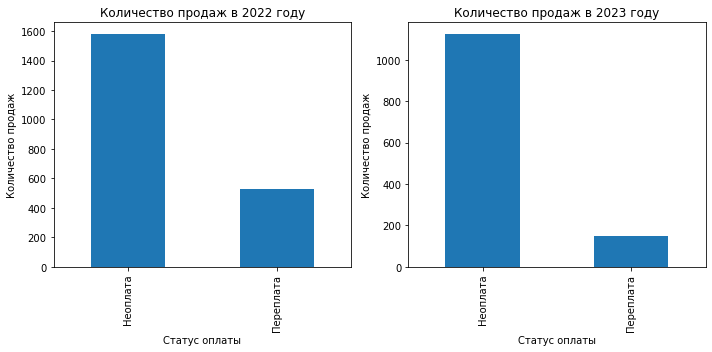

In [126]:
df_2022 = df_filter[df_filter['Год продажи'] == 2022]
df_2022 = df_2022[df_2022['Статус оплаты'] != "0"]
df_2022 = df_2022.groupby([df_2022['Статус оплаты']])['Сумма'].count()
df_2022 = df_2022.sort_values(ascending=False)

df_2023 = df_filter[df_filter['Год продажи'] == 2023]
df_2023 = df_2023[df_2023['Статус оплаты'] != "0"]
df_2023 = df_2023.groupby([df_2023['Статус оплаты']])['Сумма'].count()
df_2023 = df_2023.sort_values(ascending=False)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df_2022.plot(kind='bar')
plt.ylabel('Количество продаж') 
plt.title('Количество продаж в 2022 году')

plt.subplot(1, 2, 2)
df_2023.plot(kind='bar')
plt.ylabel('Количество продаж') 
plt.title('Количество продаж в 2023 году')


plt.tight_layout()

plt.show()

In [127]:
df_2022 = df_filter[df_filter['Год продажи'] == 2022]
df_2022 = df_2022[df_2022['Статус оплаты'] != "0"]
df_2022 = df_2022[df_2022['Статус оплаты'] != "Переплата"]
df_2022 = df_2022.groupby([df_2022['Статус оплаты']])['Сумма'].count()

df_2023 = df_filter[df_filter['Год продажи'] == 2023]
df_2023 = df_2023[df_2023['Статус оплаты'] != "0"]
df_2023 = df_2023[df_2023['Статус оплаты'] != "Переплата"]
df_2023 = df_2023.groupby([df_2023['Статус оплаты']])['Сумма'].count()

print('Изменение количества продаж с не оплатой соcтавило:', abs(df_2023-df_2022))

Изменение количества продаж с не оплатой соcтавило: Статус оплаты
Неоплата    455
Name: Сумма, dtype: int64


In [128]:
df_2022 = df_filter[df_filter['Год продажи'] == 2022]
df_2022 = df_2022[df_2022['Статус оплаты'] != "0"]
df_2022 = df_2022[df_2022['Статус оплаты'] != "Неоплата"]
df_2022 = df_2022.groupby([df_2022['Статус оплаты']])['Сумма'].count()

df_2023 = df_filter[df_filter['Год продажи'] == 2023]
df_2023 = df_2023[df_2023['Статус оплаты'] != "0"]
df_2023 = df_2023[df_2023['Статус оплаты'] != "Неоплата"]
df_2023 = df_2023.groupby([df_2023['Статус оплаты']])['Сумма'].count()

print('Изменение количества продаж с переплатой соcтавило:', abs(df_2023-df_2022))

Изменение количества продаж с переплатой соcтавило: Статус оплаты
Переплата    376
Name: Сумма, dtype: int64


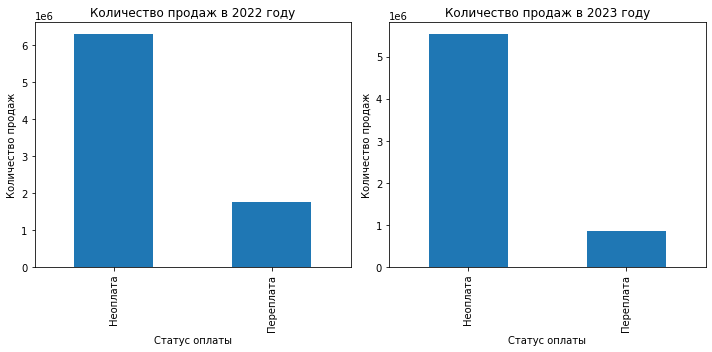

In [129]:
df_2022 = df_filter[df_filter['Год продажи'] == 2022]
df_2022 = df_2022[df_2022['Статус оплаты'] != "0"]
df_2022 = df_2022.groupby([df_2022['Статус оплаты']])['Сумма'].sum()
df_2022 = df_2022.sort_values(ascending=False)

df_2023 = df_filter[df_filter['Год продажи'] == 2023]
df_2023 = df_2023[df_2023['Статус оплаты'] != "0"]
df_2023 = df_2023.groupby([df_2023['Статус оплаты']])['Сумма'].sum()
df_2023 = df_2023.sort_values(ascending=False)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df_2022.plot(kind='bar')
plt.ylabel('Количество продаж') 
plt.title('Количество продаж в 2022 году')

plt.subplot(1, 2, 2)
df_2023.plot(kind='bar')
plt.ylabel('Количество продаж') 
plt.title('Количество продаж в 2023 году')


plt.tight_layout()

plt.show()

In [130]:
df_2022 = df_filter[df_filter['Год продажи'] == 2022]
df_2022 = df_2022[df_2022['Статус оплаты'] != "0"]
df_2022 = df_2022[df_2022['Статус оплаты'] != "Переплата"]
df_2022 = df_2022.groupby([df_2022['Статус оплаты']])['Сумма'].sum()

df_2023 = df_filter[df_filter['Год продажи'] == 2023]
df_2023 = df_2023[df_2023['Статус оплаты'] != "0"]
df_2023 = df_2023[df_2023['Статус оплаты'] != "Переплата"]
df_2023 = df_2023.groupby([df_2023['Статус оплаты']])['Сумма'].sum()

print('Изменение суммы не оплаченных продаж соcтавило:', abs(df_2023-df_2022))

Изменение суммы не оплаченных продаж соcтавило: Статус оплаты
Неоплата    753757.533503
Name: Сумма, dtype: float64


In [131]:
df_2022 = df_filter[df_filter['Год продажи'] == 2022]
df_2022 = df_2022[df_2022['Статус оплаты'] != "0"]
df_2022 = df_2022[df_2022['Статус оплаты'] != "Неоплата"]
df_2022 = df_2022.groupby([df_2022['Статус оплаты']])['Сумма'].sum()

df_2023 = df_filter[df_filter['Год продажи'] == 2023]
df_2023 = df_2023[df_2023['Статус оплаты'] != "0"]
df_2023 = df_2023[df_2023['Статус оплаты'] != "Неоплата"]
df_2023 = df_2023.groupby([df_2023['Статус оплаты']])['Сумма'].sum()

print('Изменение суммы продаж с переплатой соcтавило:', abs(df_2023-df_2022))

Изменение суммы продаж с переплатой соcтавило: Статус оплаты
Переплата    912234.107457
Name: Сумма, dtype: float64


Количество не оплаченных заказов в 2023 году уменьшилось на 455. Сумма не оплаченных заказов в 2023 году уменьшилась на 753757,53.
Переплата в 2023 году также падает по количеству (376) и стоимости (912234.11)

# Прогноз продаж

In [132]:
df_count = df_filter.groupby('Дата продажи').size().reset_index(name='Count')
df_count['Дата продажи'] = pd.to_datetime(df_count['Дата продажи'], format='%Y-%m-%d %H:%M:%S')
df_count = df_count.set_index('Дата продажи')
df_count

,Count
Дата продажи,
2022-01-02,1
2022-01-03,6
2022-01-04,13
2022-01-05,23
2022-01-06,13
...,...
2023-12-26,98
2023-12-27,71
2023-12-28,63


In [133]:
df_count = df_count.resample('1D').sum()
df_count

,Count
Дата продажи,
2022-01-02,1
2022-01-03,6
2022-01-04,13
2022-01-05,23
2022-01-06,13
...,...
2023-12-26,98
2023-12-27,71
2023-12-28,63


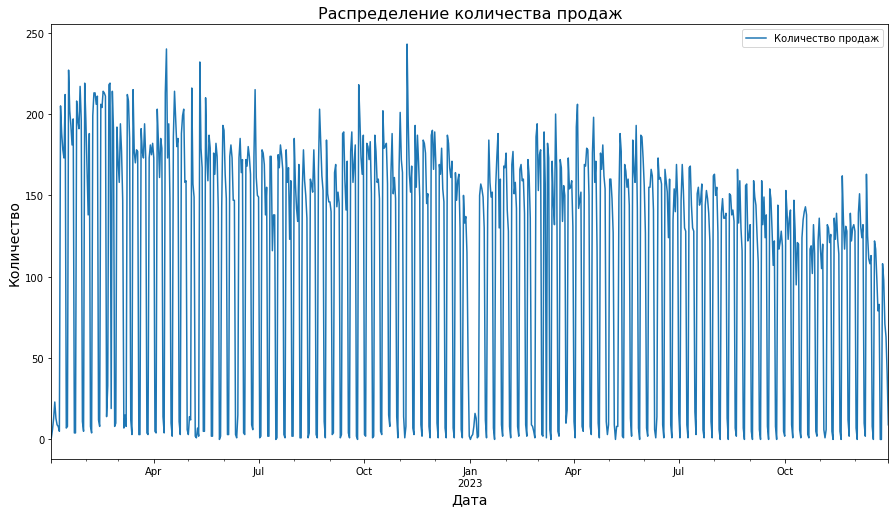

In [134]:
df_count.plot(figsize=(15,8))
plt.legend(['Количество продаж'])
plt.title('Распределение количества продаж', fontsize=16)
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Дата', fontsize=14);

Стандартное отклонение = 21.140426667399332


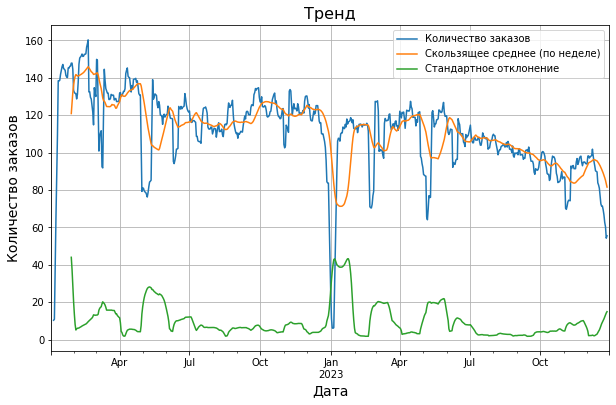

In [135]:
# Тренд

decomposed = seasonal_decompose(df_count)

decomposed.trend.plot(ax=plt.gca(), figsize=(10,6))
decomposed.trend.rolling(24*1).mean().plot(ax=plt.gca())
decomposed.trend.rolling(24*1).std().plot(ax=plt.gca())
plt.legend(['Количество заказов', 'Скользящее среднее (по неделе)', 'Стандартное отклонение'])
plt.title('Тренд', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid();

print('Стандартное отклонение =', decomposed.trend.std())

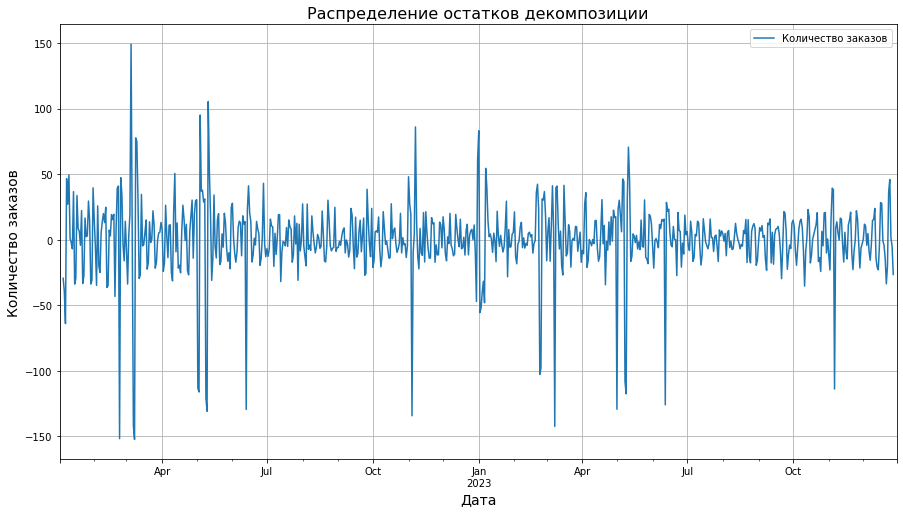

In [136]:
decomposed.resid.plot(figsize=(15,8))
plt.legend(['Количество заказов'])
plt.title('Распределение остатков декомпозиции', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid();

In [137]:
def make_features(df_count, max_lag, rolling_mean_size):
    df_count['dayofweek'] = df_count.index.dayofweek
    df_count['day'] = df_count.index.day
    
    for lag in range(1, max_lag + 1):
        df_count['lag_{}'.format(lag)] = df_count['Count'].shift(lag)

    df_count['rolling_mean'] = df_count['Count'].shift().rolling(rolling_mean_size).mean()

In [138]:
make_features(df_count, 5, 4)

In [139]:
df_count

,Count,dayofweek,day,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
Дата продажи,,,,,,,,,
2022-01-02,1,6,2,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03,6,0,3,1.0,NaN,NaN,NaN,NaN,NaN
2022-01-04,13,1,4,6.0,1.0,NaN,NaN,NaN,NaN
2022-01-05,23,2,5,13.0,6.0,1.0,NaN,NaN,NaN
2022-01-06,13,3,6,23.0,13.0,6.0,1.0,NaN,10.75
...,...,...,...,...,...,...,...,...,...
2023-12-26,98,1,26,108.0,0.0,0.0,83.0,79.0,47.75
2023-12-27,71,2,27,98.0,108.0,0.0,0.0,83.0,51.50
2023-12-28,63,3,28,71.0,98.0,108.0,0.0,0.0,69.25


In [140]:
df_count = df_count.dropna()

features = df_count.drop(['Count'], axis=1)
target = df_count['Count']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            shuffle=False,
                                                                            test_size=0.1,
                                                                            random_state=RS)

In [141]:
print('Размер тренировочной выборки {:.0%}'.format(features_train.shape[0] / features.shape[0]))
print('Размер тестовой выборки {:.0%}'.format(features_test.shape[0] / features.shape[0]))

Размер тренировочной выборки 90%
Размер тестовой выборки 10%


Создадим копии выборок, признаки в которых в дальнейшем будут кодироваться.

Будем применять:

ОНЕ кодирование - для модели LinearRegression
OE кодирование - для модели ForestRegressor

In [142]:
# Для ОНЕ кодирования
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()
target_train_ohe = target_train.copy()
target_test_ohe = target_test.copy()


# Для ОЕ кодирования
features_train_oe = features_train.copy()
features_test_oe = features_test.copy()
target_train_oe = target_train.copy()
target_test_oe = target_test.copy()

In [143]:
# OHE кодирование

columns_ohe = ['dayofweek', 'day']

encoder_ohe = OneHotEncoder(drop='first')
encoder_ohe.fit(features_train_ohe[columns_ohe])

features_ohe_train = pd.DataFrame(encoder_ohe.transform(features_train_ohe[columns_ohe]).toarray(),
                                  index=features_train_ohe.index)
features_ohe_test = pd.DataFrame(encoder_ohe.transform(features_test_ohe[columns_ohe]).toarray(),
                                 index=features_test_ohe.index)

features_ohe_train.columns = encoder_ohe.get_feature_names(columns_ohe)
features_ohe_test.columns = encoder_ohe.get_feature_names(columns_ohe)

features_train_ohe = pd.concat([features_train_ohe, features_ohe_train], axis=1)
features_test_ohe = pd.concat([features_test_ohe, features_ohe_test], axis=1)

features_train_ohe = features_train_ohe.drop(columns_ohe, axis=1)
features_test_ohe = features_test_ohe.drop(columns_ohe, axis=1)

In [144]:
# OE кодирование

columns_oe = ['dayofweek', 'day']

encoder_oe = OrdinalEncoder()
encoder_oe.fit(features_train_oe[columns_oe])

features_train_oe[columns_oe] = encoder_oe.transform(features_train_oe[columns_oe]) 
features_test_oe[columns_oe] = encoder_oe.transform(features_test_oe[columns_oe])

In [145]:
# Посмотрим на данные после кодирования

print('Исходная таблица')
display(features_train.head())

print('Данные после OE кодирования')
display(features_train_oe.head())

print('Данные после ОНЕ кодирования')
display(features_train_ohe.head())

Исходная таблица


,dayofweek,day,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
Дата продажи,,,,,,,,
2022-01-07,4,7,13.0,23.0,13.0,6.0,1.0,13.75
2022-01-08,5,8,9.0,13.0,23.0,13.0,6.0,14.50
2022-01-09,6,9,8.0,9.0,13.0,23.0,13.0,13.25
2022-01-10,0,10,5.0,8.0,9.0,13.0,23.0,8.75
2022-01-11,1,11,205.0,5.0,8.0,9.0,13.0,56.75


Данные после OE кодирования


,dayofweek,day,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
Дата продажи,,,,,,,,
2022-01-07,4.0,6.0,13.0,23.0,13.0,6.0,1.0,13.75
2022-01-08,5.0,7.0,9.0,13.0,23.0,13.0,6.0,14.50
2022-01-09,6.0,8.0,8.0,9.0,13.0,23.0,13.0,13.25
2022-01-10,0.0,9.0,5.0,8.0,9.0,13.0,23.0,8.75
2022-01-11,1.0,10.0,205.0,5.0,8.0,9.0,13.0,56.75


Данные после ОНЕ кодирования


,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
Дата продажи,,,,,,,,,,,,,,,,,,,,,
2022-01-07,13.0,23.0,13.0,6.0,1.0,13.75,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-08,9.0,13.0,23.0,13.0,6.0,14.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-09,8.0,9.0,13.0,23.0,13.0,13.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-10,5.0,8.0,9.0,13.0,23.0,8.75,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-11,205.0,5.0,8.0,9.0,13.0,56.75,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# LinearRegression

In [146]:
%%time

model_LR = LinearRegression()
parameters_LR = {'fit_intercept':[True,False], 'normalize':[True,False]}
tss_cv = TimeSeriesSplit(n_splits=5)
grid_LR = GridSearchCV(model_LR, parameters_LR, cv=tss_cv, scoring='neg_root_mean_squared_error')
grid_LR.fit(features_train_ohe, target_train_ohe)

print('Лучшие параметры модели = ', grid_LR.best_params_)
print('RMSE модели =', grid_LR.best_score_*(-1)) 

Лучшие параметры модели =  {'fit_intercept': True, 'normalize': False}
RMSE модели = 34.57996832295226
Wall time: 479 ms


# RandomForestRegressor

In [147]:
%%time


model_RFR = RandomForestRegressor(random_state=RS)
parameters_RFR = {'n_estimators': range(100, 300, 50),
                  'max_depth': range(5,10)}
tss_cv = TimeSeriesSplit(n_splits=5)
grid_RFR = GridSearchCV(model_RFR, parameters_RFR, cv=tss_cv, scoring='neg_root_mean_squared_error', verbose=100)
grid_RFR.fit(features_train_oe, target_train_oe)

print('Лучшие параметры модели = ', grid_RFR.best_params_)
print('RMSE модели', grid_RFR.best_score_*(-1))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START max_depth=5, n_estimators=100..............................
[CV 1/5; 1/20] END ............max_depth=5, n_estimators=100; total time=   0.0s
[CV 2/5; 1/20] START max_depth=5, n_estimators=100..............................
[CV 2/5; 1/20] END ............max_depth=5, n_estimators=100; total time=   0.0s
[CV 3/5; 1/20] START max_depth=5, n_estimators=100..............................
[CV 3/5; 1/20] END ............max_depth=5, n_estimators=100; total time=   0.0s
[CV 4/5; 1/20] START max_depth=5, n_estimators=100..............................
[CV 4/5; 1/20] END ............max_depth=5, n_estimators=100; total time=   0.1s
[CV 5/5; 1/20] START max_depth=5, n_estimators=100..............................
[CV 5/5; 1/20] END ............max_depth=5, n_estimators=100; total time=   0.1s
[CV 1/5; 2/20] START max_depth=5, n_estimators=150..............................
[CV 1/5; 2/20] END ............max_depth=5, n_e

[CV 1/5; 11/20] END ...........max_depth=7, n_estimators=200; total time=   0.1s
[CV 2/5; 11/20] START max_depth=7, n_estimators=200.............................
[CV 2/5; 11/20] END ...........max_depth=7, n_estimators=200; total time=   0.2s
[CV 3/5; 11/20] START max_depth=7, n_estimators=200.............................
[CV 3/5; 11/20] END ...........max_depth=7, n_estimators=200; total time=   0.2s
[CV 4/5; 11/20] START max_depth=7, n_estimators=200.............................
[CV 4/5; 11/20] END ...........max_depth=7, n_estimators=200; total time=   0.3s
[CV 5/5; 11/20] START max_depth=7, n_estimators=200.............................
[CV 5/5; 11/20] END ...........max_depth=7, n_estimators=200; total time=   0.3s
[CV 1/5; 12/20] START max_depth=7, n_estimators=250.............................
[CV 1/5; 12/20] END ...........max_depth=7, n_estimators=250; total time=   0.2s
[CV 2/5; 12/20] START max_depth=7, n_estimators=250.............................
[CV 2/5; 12/20] END ........

# Сравнение моделей и обучение на тестовой выборке

In [148]:
print('RMSE модели LinearRegression =', grid_LR.best_score_*(-1))
print('RMSE модели RandomForestRegressor =', grid_RFR.best_score_*(-1))
#print('RMSE модели CatBoostRegressor =', grid_CBR.best_score_*(-1))

RMSE модели LinearRegression = 34.57996832295226
RMSE модели RandomForestRegressor = 32.67816152661963


Будем использоавать рандом форест

In [149]:
predict = grid_RFR.predict(features_test_oe)
rmse = sqrt(mean_squared_error(target_test_oe, predict))

print('RMSE модели =', rmse)

RMSE модели = 31.07343905904757


In [150]:
result = pd.DataFrame(pd.Series(predict))
result.index=features_test.index
result.columns = ['predicted']

result['real'] = target_test


result.head(10)

,predicted,real
Дата продажи,,
2023-10-19,142.981680,143
2023-10-20,140.935341,138
2023-10-21,8.864934,3
2023-10-22,1.126964,1
2023-10-23,152.524798,117
2023-10-24,151.164799,119
2023-10-25,139.996806,102
2023-10-26,135.832459,132
2023-10-27,136.822048,114


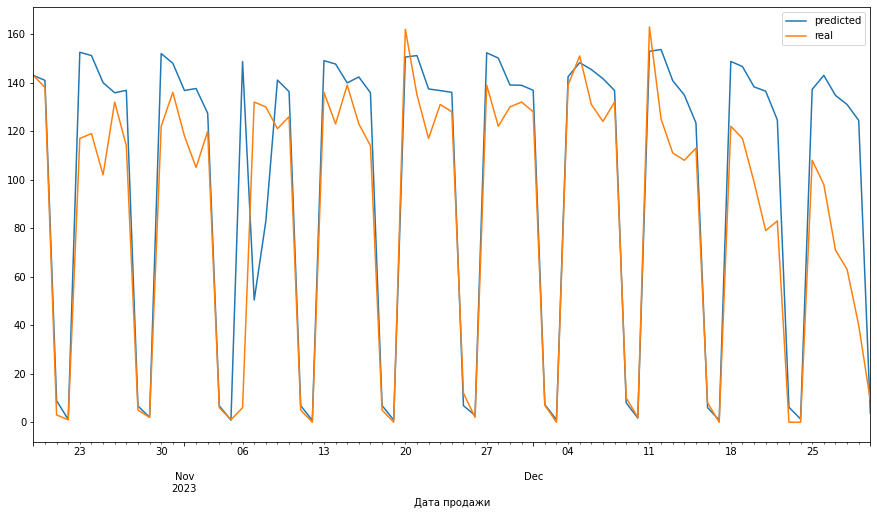

In [151]:
result.plot(figsize=(15,8));

Модель показала высокую сходимость результатов

# ВЫВОДЫ
Наблюдается падение продаж услуг за 2023 год (-7212 штук) и, как следствие, падение выручки (-21921764.43 у.е.). По клиентам в в первой пятерке как по количеству услуг, так и по стоимости изменеий не наблюдается.
Количество не оплаченных заказов в 2023 году уменьшилось на 455. Сумма не оплаченных заказов в 2023 году уменьшилась на 753757,53. Переплата в 2023 году также падает по количеству (376) и стоимости (912234.11).

Точка роста - увеличение количества продаж, проведение рекламных и промо компаний.